# Assignment 5

### Intro
In this assignment, you will design a Convolutional Neural Network (CNN) based algorithm that can automatically identify hand-written digits.

We will be using the Keras API to design our CNN. Keras is a high-level library that builds on top of lower-level libraries like Tensorflow and Theano. In other words, Keras can be thought of as a front-end API which uses a backend engine for its computations. For example, we can use Keras with a Tensorflow or Theano backend. Since Keras does not yet support PyTorch, we will be using the Tensorflow backend (Theano is not widely used anymore). Follow the README to install both Tensorflow and Keras.

The nice thing about APIs like Keras is that we can create models quickly without having to worry about the underlying implementation. However, for highly customzed algorithms it is usually necessary to work with the lower-level libraries like PyTorch or Tensorflow.

You should definitely read this before attempting this assignment: https://keras.io/getting-started/sequential-model-guide/

Essentially Keras has two ways of defining a model: Sequentially or Functionally. We use the sequential approach in this assignment but you are more than welcome to try the functional approach as this is more commonly used.

### Background
The dataset we will use is a variant of the orignal MNIST handwritten digit dataset. In this variant, each image (input) contains two or three digits from the original MNIST dataset randomly scaled to 40/60/80/100/120 percent of the original digit size and spliced together at different angles.

For each image in the modified dataset, the correct label corresponds to the digit with the maximum area. More precisely, this area refers to area of the rectangle which encompasses the digit.

We will use 39999 images for training and 10000 images for testing.

Download the dataset files here:

[Features](https://drive.google.com/file/d/1ZWQN6Y4Pm70k25ONmDOgbZOwVGhBITov/view?usp=sharing)

[Labels](https://drive.google.com/file/d/11I7RgSYMhF5bWGDMRFOiEkeQ-DyZjhAj/view?usp=sharing)

### Your task
Your task for this assignment is to improve the base model and achieve an accuracy of 95% or above on the test set. You will do this by making the model more complex by doing the following:
1. Changing the architecture of the model by adding Conv2d, Dense(feed-forward), Pooling, [Dropout](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5), and any other layers that make sense.
2. Playing around the parameters of the layers. Do some quick research to see what kind of pooling, for example, could be effective in this task and experiment!
3. Modify the preprocess function if you think you can do better

### Note:
This assignment may take a while to complete (mostly due to training time). If you find that it is taking too long, reduce the batch size (to some lower power of 2) and reduce the number of epochs from 10 to a lower number. Whatever accuracy you end up with does not matter as long as we see that you have tried you complete this assignment :)

In [ ]:
# Python imports
import os

# Data manipulation imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# ML Imports
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import InputLayer
from keras.layers import Reshape, MaxPooling2D, ZeroPadding2D, Dropout
from keras.layers import Conv2D, Dense, Flatten
from keras.utils import to_categorical

# IPython display
from IPython.display import display

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

SystemError: <class '_frozen_importlib._ModuleLockManager'> returned a result with an error set

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import

### First we declare some constants relating to our input and training

In [22]:
BATCH_SIZE = 64 # Reduce this to 256, 128, 64, etc if your computer is too slow
IMG_SIZE = 64 # Images are 64x64
NUM_CHANNELS = 1 # Images can have multiple channels eg. rgb. These images are grayscale so we have just 1 channel
NUM_CLASSES = 10 # Digits 0-9, so we have 10 classes

IMG_SIZE_FLAT = IMG_SIZE ** 2 # 64^2 = 4096, the number of pixels per image
IMG_SHAPE = (IMG_SIZE, IMG_SIZE)
IMG_SHAPE_CHANNELS = (IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
INPUT_SHAPE = (-1, IMG_SIZE, IMG_SIZE, NUM_CHANNELS)

### Helper functions

In [3]:
def preprocess(x):
    '''
    Simple preprocessing function that removes the background from the images and normalizes pixel values between 0 and 1
    :param x: Input array or dataframe
    '''
    x[x < 255] = 0 # Remove background
    return x / 255.0 # normalize

def show_data(X, y_true=None, y_pred=None, n_examples=10, shape=IMG_SHAPE):
    '''
    Displays the images X along with actual and predicted labels if provided.
    :param X: The array of images.
    :param y_true: The true labels
    :param y_pred: The predicted labels
    :param n_examples: The number of images to show.
    :param shape: If images are flattened, reshapes to shape
    :return: None
    '''
    for i in range(n_examples):
        image = np.array(X[i], dtype=np.float32)
        pixels = image.reshape(shape)
        plt.imshow(pixels, cmap='binary')
        plt.xlabel('Actual: {} Pred: {}'.format(y_true[i] if y_true is not None else None, 
                                                y_pred[i] if y_pred is not None else None))
        plt.show()

def predict(model, X):
    '''
    Given a Keras model, performs prediction and computes the labels
    :param model: Keras model
    :param X: Input features
    :return: Predicted labels
    '''
    y_pred = model.predict(X)
    y_pred = np.argmax(y_pred, axis=1)
    return y_pred

In [5]:
X = pd.read_csv('~/Desktop/modified_mnist_x.csv', dtype=np.float32)
y = pd.read_csv('~/Desktop/modified_mnist_y.csv', dtype=np.float32)

In [6]:
display(X.head())
display(y.head())

,149.000000,155.000000,154.000000,158.000000,158.000000.1,156.000000,156.000000.1,158.000000.2,156.000000.2,153.000000,...,182.000000.30,179.000000.109,173.000000.140,181.000000.67,185.000000.17,184.000000.19,181.000000.68,177.000000.119,174.000000.129,173.000000.141
0,52.0,54.0,55.0,37.0,37.0,37.0,37.0,38.0,38.0,38.0,...,36.0,39.0,40.0,38.0,37.0,40.0,43.0,42.0,55.0,55.0
1,109.0,113.0,117.0,116.0,110.0,102.0,94.0,91.0,101.0,109.0,...,82.0,85.0,86.0,96.0,118.0,119.0,108.0,95.0,74.0,71.0
2,176.0,177.0,177.0,177.0,169.0,159.0,158.0,167.0,175.0,188.0,...,170.0,171.0,142.0,118.0,115.0,120.0,108.0,80.0,41.0,29.0
3,64.0,29.0,30.0,30.0,32.0,32.0,32.0,35.0,30.0,32.0,...,35.0,37.0,38.0,33.0,119.0,101.0,39.0,45.0,48.0,52.0
4,123.0,123.0,123.0,121.0,117.0,111.0,105.0,101.0,100.0,115.0,...,61.0,56.0,58.0,57.0,57.0,57.0,57.0,55.0,51.0,49.0


,4
0,7.0
1,1.0
2,0.0
3,8.0
4,7.0


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [8]:
display(X_train.shape)
display(X_test.shape)

(39999, 4096)

(10000, 4096)

### First we reshape the flattenend images into 64x64x1 (The 1 is because we have 1 channel. If we had rgb, then it would be 64x64x3)

In [9]:
X_train = np.reshape(X_train.values, INPUT_SHAPE)
X_test = np.reshape(X_test.values, INPUT_SHAPE)
y_train = y_train.values
y_test = y_test.values

### Let's take a look at our data

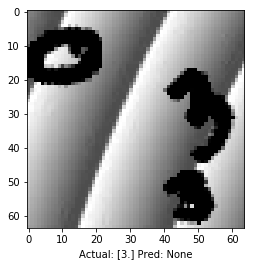

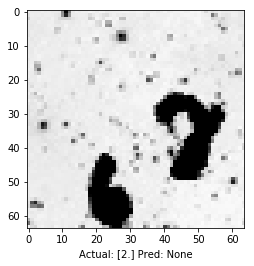

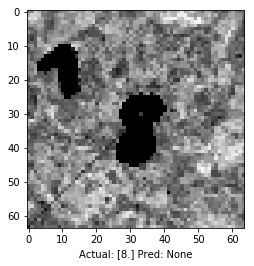

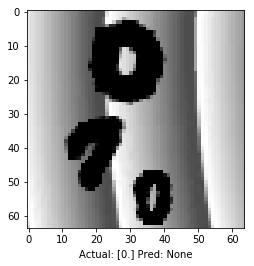

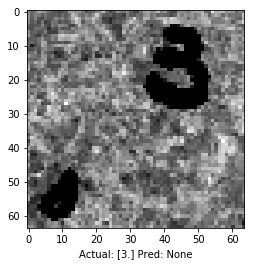

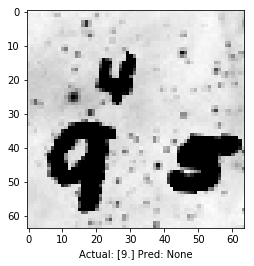

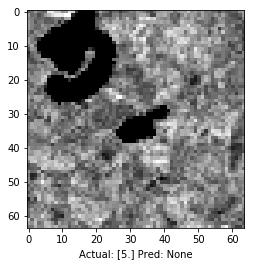

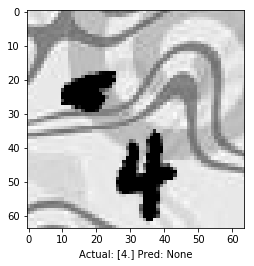

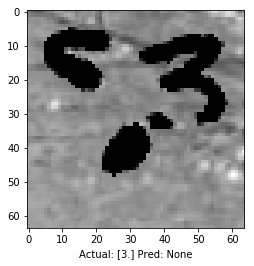

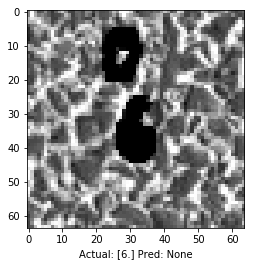

In [10]:
show_data(X_train, y_train)

### We notice that the digits themselves are always black, and the backgrounds are of a different shade. This implies we could remove the background. Let's do that

In [11]:
X_train = preprocess(X_train)
X_test = preprocess(X_test)

In [12]:
display(X_train.shape) # Now our inputs have been reshaped, so we have a 4D array, with each item representing an image.
display(X_test.shape)

(39999, 64, 64, 1)

(10000, 64, 64, 1)

### Categorical labels should always be one-hot encoded

In [13]:
y_train_enc = to_categorical(y_train, NUM_CLASSES)
y_test_enc = to_categorical(y_test, NUM_CLASSES)

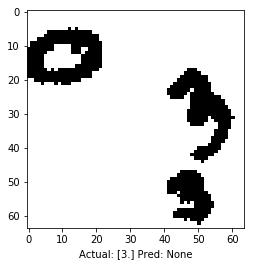

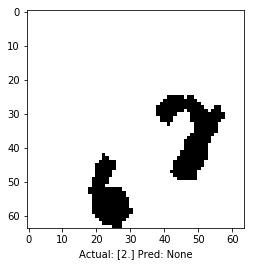

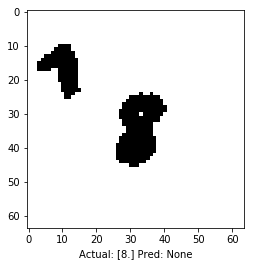

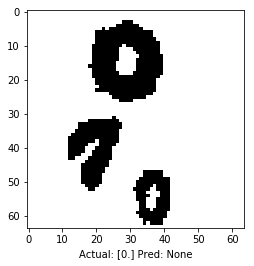

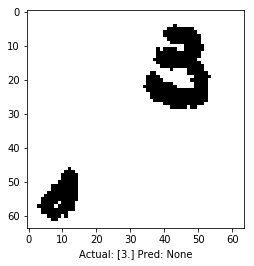

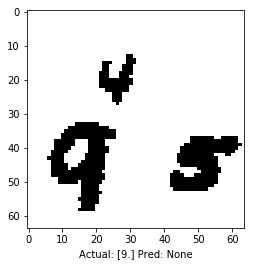

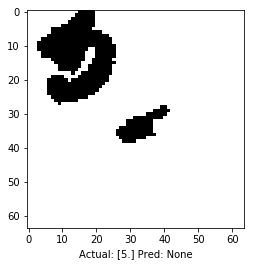

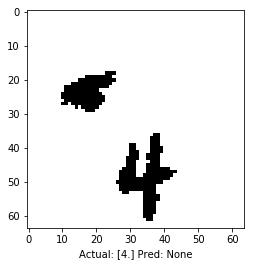

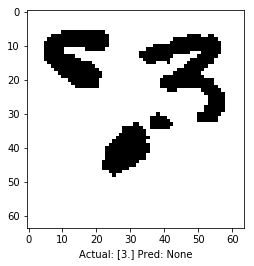

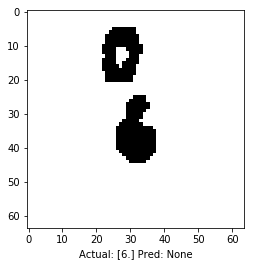

In [14]:
show_data(X_train, y_train)

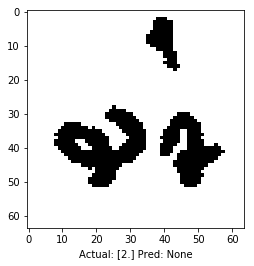

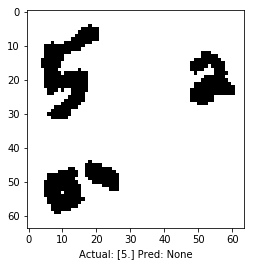

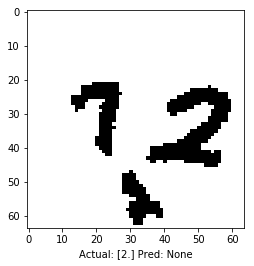

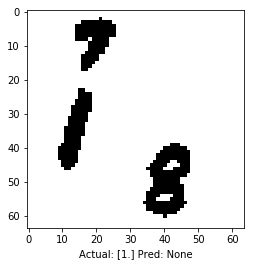

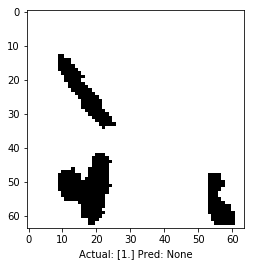

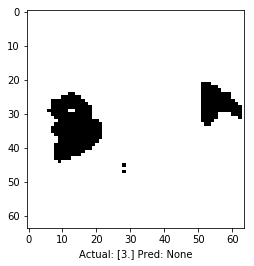

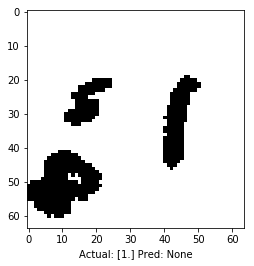

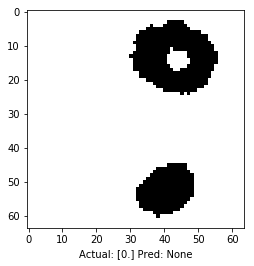

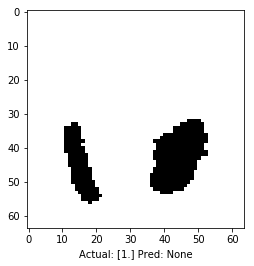

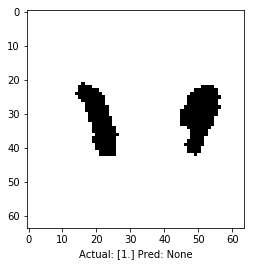

In [15]:
show_data(X_test, y_test)

### Now we define our base model

This is a very simple CNN architecture similar to what you learned in the lecture. We have cascading blocks of convolutional layers followed by pooling layers.

In [17]:
def create_base_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=IMG_SHAPE_CHANNELS))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))

    model.add(Dense(1024, activation='relu'))

    model.add(Dense(NUM_CLASSES, activation='softmax'))

    return model

In [18]:
model_base = create_base_model()
model_base.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
model_base.fit(x=X_train, y=y_train_enc, epochs=10, batch_size=BATCH_SIZE)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
39999/39999 [==============================] - 573s 14ms/step - loss: 2.4001 - acc: 0.1104
Epoch 2/10
39999/39999 [==============================] - 549s 14ms/step - loss: 2.3073 - acc: 0.1125
Epoch 3/10
39999/39999 [==============================] - 534s 13ms/step - loss: 2.3037 - acc: 0.1098
Epoch 4/10
39999/39999 [==============================] - 478s 12ms/step - loss: 2.3017 - acc: 0.1114
Epoch 5/10
39999/39999 [==============================] - 540s 14ms/step - loss: 2.3017 - acc: 0.1114
Epoch 6/10
39999/39999 [==============================] - 535s 13ms/step - loss: 2.3017 - acc: 0.1114
Epoch 7/10
39999/39999 [==============================] - 1077s 27ms/step - loss: 2.3017 - acc: 0.1114
Epoch 8/10
39999/39999 [==============================] - 622s 16ms/step - loss: 2.3016 - acc: 0.1114
Epoch 9/10
39999/39999 [==============================] - 476s 12ms/step - loss: 2.3016 - acc: 0.1114
Epoch 10/10
39999/39999 [========

In [33]:
y_pred = predict(model_base, X_test)
print('Your accuracy is:', accuracy_score(y_test, y_pred))

Your accuracy is: 0.1114


## Your task

Complete the create_model function which will return a Keras model. You may use either the Sequential or Functional Keras API.

Compile your model and fit the training set as shown above. Predict on the test set and check your accuracy.


In [30]:
def create_model():
    
    model = Sequential()
    #### 1st layer ###
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=IMG_SHAPE_CHANNELS))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
   
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #### 2nd layer ####
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Dropout(0.2))                                       
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    ### 3rd layer ####
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    
    ### 4th layer ####
    model.add(Dense(64, activation='relu'))
    
    #### 5th layer ####
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model

In [31]:
model = create_model()
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
model_base.fit(x=X_train, y=y_train_enc, epochs=5, batch_size=BATCH_SIZE)

Epoch 1/5
39999/39999 [==============================] - 449s 11ms/step - loss: 2.3018 - acc: 0.1114
Epoch 2/5
39999/39999 [==============================] - 448s 11ms/step - loss: 2.3017 - acc: 0.1114
Epoch 3/5
39999/39999 [==============================] - 449s 11ms/step - loss: 2.3017 - acc: 0.1114
Epoch 4/5
39999/39999 [==============================] - 570s 14ms/step - loss: 2.3017 - acc: 0.1114
Epoch 5/5
39999/39999 [==============================] - 2407s 60ms/step - loss: 2.3017 - acc: 0.1114


In [34]:
y_pred = predict(model, X_test)
print('Your accuracy is:', accuracy_score(y_test, y_pred))

Your accuracy is: 0.0985


In [3]:
def create_model_2():
    
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model

In [4]:
model = create_model_2()
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

NameError: name 'Sequential' is not defined